# Example use on mvtec dataset

#### Import dependencies

In [15]:
import image_anomaly_detection as iad

import torch
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt

#### Set device

In [16]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')  # The training process requires quite a lot of RAM, so you might have to run it on the cpu
print("Device:", device)

Device: cpu


#### Choose a model to extract features from

In [17]:
features_model = iad.Resnet18Features(device)

#### If you do not want all the dimensions of the embedding vectors, choose the wanted indices

In [18]:
indices = iad.get_original_resnet18_indices(device)

## 
## Training

#### Load dataset

In [19]:
class_name = 'bottle'
data_path = '../../data/mvtec_dataset/' # Path to mvtec dataset
dataset = iad.MVTecDataset(data_path, class_name=class_name, is_train=True)
dataloader = DataLoader(dataset, batch_size=32, pin_memory=True)
print("Number of images in dataset:", len(dataset))

Number of images in dataset: 209


#### Extract the embedding vectors from the whole dataset

In [20]:
embedding_vectors = iad.extract_embedding_vectors_dataloader(features_model, dataloader, device, indices=indices)
print("Shape of embedding vectors:", embedding_vectors.shape)

Feature extraction: 100%|██████████| 7/7 [00:13<00:00,  1.94s/it]

Shape of embedding vectors: torch.Size([209, 100, 56, 56])


#### Calculate the means and the inverse of the covariance matrices for the embedding vectors

In [22]:
mean, cov_inv = iad.joint_normal_distribution(embedding_vectors)

#### Save the distributions

In [23]:
distributions_path = '../distributions/'
torch.save(mean, distributions_path+'bottle_mean.pt')
torch.save(cov_inv, distributions_path+'bottle_cov_inv.pt')

## 
## Inference

In [24]:
distributions_path = '../distributions/'
mean = torch.load(distributions_path+'bottle_mean.pt').to(device)
cov_inv = torch.load(distributions_path+'bottle_cov_inv.pt').to(device)

#### Load images

In [25]:
paths = [
    '../../data/mvtec_dataset/bottle/test/broken_large/000.png',
    '../../data/mvtec_dataset/bottle/test/broken_small/000.png',
    '../../data/mvtec_dataset/bottle/test/contamination/000.png',
    '../../data/mvtec_dataset/bottle/test/good/000.png',
    '../../data/mvtec_dataset/bottle/test/good/001.png',
]
images = []
for path in paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

#### Convert to batch

In [26]:
batch = iad.to_batch(images, device)
batch.shape

torch.Size([5, 3, 224, 224])

#### Calculate scores and classifications

In [27]:
patch_scores, image_scores, patch_classifications, image_classifications = iad.anomaly_detection(batch, features_model, mean, cov_inv, device, 10, indices=indices)
print("Image scores:", image_scores)
print("Image classifications:", image_classifications)

Image scores: tensor([19.6080, 11.5092, 18.3492,  6.9911,  5.6536])
Image classifications: tensor([0., 0., 0., 1., 1.])


#### Visualize result

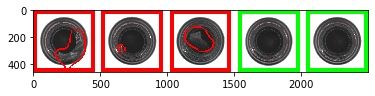

In [28]:
img = iad.boundary_image_classification_group(images, patch_classifications, image_classifications, 400)
plt.imshow(img)
plt.show()

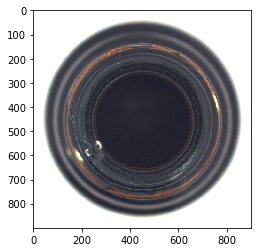

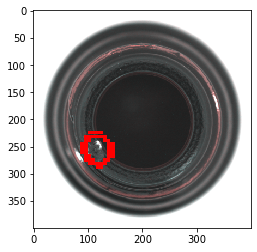

In [29]:
idx = 1
img = iad.boundary_image(images[idx], patch_classifications[idx], 400)
plt.imshow(images[idx])
plt.show()
plt.imshow(img)
plt.show()